In [1]:
%matplotlib inline

# Map Traversal Using An Artificial Neural Network



Imagine an agent exploring a world filled with plains, forests, swamps, hills and mountains as represented by the map with following known terrain:

```
......
...**.
...***
..^...
..~^..
```

but what if all we know is that we have some area of interest, that we've reduced to a GPS grid:

```
??????
??????
??????
??????
??????
```

and the agent has to determine what kind of terrain is to the left, front and right of it?

Assuming the agent has a very simple visual sensor that constructs a 4x4 grayscale image for each of the three directions, it might it could see something like this:

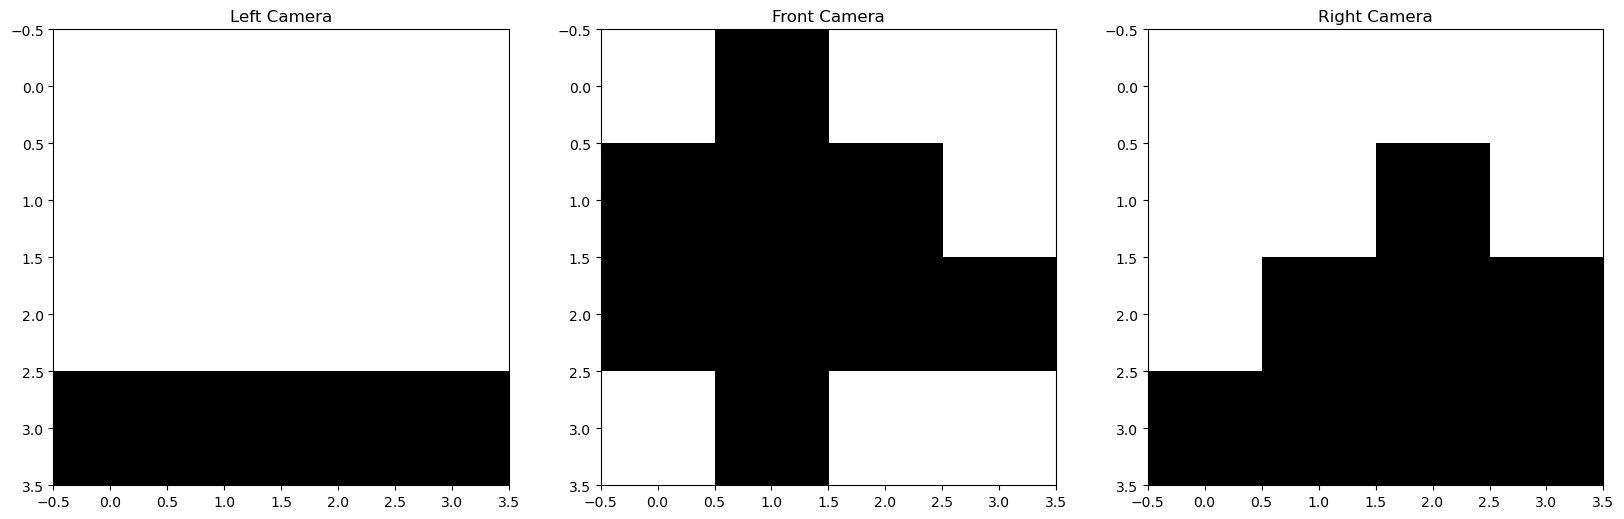

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random

plain =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 1.0, 1.0, 1.0]
forest = [0.0, 1.0, 0.0, 0.0,1.0, 1.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0,0.0, 1.0, 0.0, 0.0]
hills =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 1.0, 0.0,0.0, 1.0, 1.0, 1.0,1.0, 1.0, 1.0, 1.0]
swamp =  [0.0, 0.0, 0.0, 0.0,0.0, 0.0, 0.0, 0.0,1.0, 0.0, 1.0, 0.0,1.0, 1.0, 1.0, 1.0]

figure = plt.figure(figsize=(20,6))

axes = figure.add_subplot(1, 3, 1)
pixels = np.array([255 - p * 255 for p in plain], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Left Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 2)
pixels = np.array([255 - p * 255 for p in forest], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Front Camera")
axes.imshow(pixels, cmap='gray')

axes = figure.add_subplot(1, 3, 3)
pixels = np.array([255 - p * 255 for p in hills], dtype='uint8')
pixels = pixels.reshape((4, 4))
axes.set_title( "Right Camera")
axes.imshow(pixels, cmap='gray')

plt.show()
plt.close()

which would be plains, forest and hills respectively.


## The Goal

We are going to create an artificial neural network that determines what kind of terrain it is. 

## Data Prep

To start, we'll need to have clean examples of the different types of terrain but based on the location, the registration can be a bit off for some of the types and the visual sensor is often blurry.

Here are the clean examples with different registrations: 

In [3]:
clean_data = {
    "plains": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, "plains"]
    ],
    "forest": [
        [0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, "forest"],
        [1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, "forest"],
        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, "forest"]
    ],
    "hills": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, "hills"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, "hills"]
    ],
    "swamp": [
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, "swamp"],
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, "swamp"]        
    ]
}

Let's create a function that allows us to view any of these:

In [4]:
def view_sensor_image( data):
    figure = plt.figure(figsize=(4,4))
    axes = figure.add_subplot(1, 1, 1)
    pixels = np.array([255 - p * 255 for p in data[:-1]], dtype='uint8')
    pixels = pixels.reshape((4, 4))
    axes.set_title( "Left Camera:" + data[-1])
    axes.imshow(pixels, cmap='gray')
    plt.show()
    plt.close()

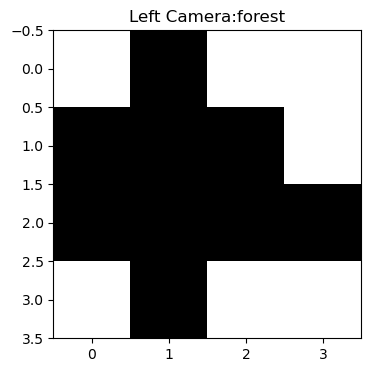

In [5]:
view_sensor_image( clean_data[ "forest"][0])

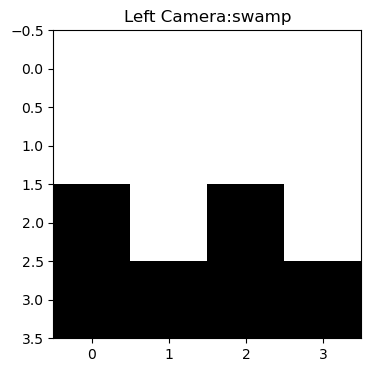

In [6]:
view_sensor_image( clean_data["swamp"][0])

The data that comes in, however, is noisy. The values are never exactly 0 and 1. In order to mimic this we need a `blur` function.

We will assume that noise is normally distributed. For values that should be 0, the noisy values are distributed $N(0.10, 0.05)$. For values should be 1, the noisy values are distributed $N(0.9, 0.10)$.

In [7]:
def blur( data):
    def apply_noise( value):
        if value < 0.5:
            v = random.gauss( 0.10, 0.05)
            if v < 0.0:
                return 0.0
            if v > 0.75:
                return 0.75
            return v
        else:
            v = random.gauss( 0.90, 0.10)
            if v < 0.25:
                return 0.25
            if v > 1.00:
                return 1.00
            return v
    noisy_readings = [apply_noise( v) for v in data[0:-1]]
    return noisy_readings + [data[-1]]

We can see how this affects what the agent *actually* sees.

In [8]:
blur(clean_data["swamp"][0])

[0.06578115810318846,
 0.059134864882229035,
 0.10221046565304268,
 0.1049182782204304,
 0.15206683057361278,
 0.19268884080800527,
 0.11252355808470214,
 0.0925490064051796,
 0.7860333150853621,
 0.11622856785697823,
 0.8928978436253706,
 0.15642541748304173,
 0.8918075922344034,
 0.6516176720148269,
 0.9327657716227868,
 0.8130637829661139,
 'swamp']

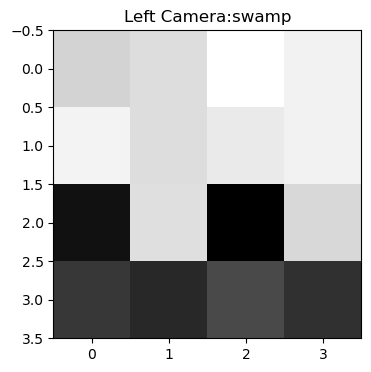

None


In [9]:
print(view_sensor_image( blur( clean_data["swamp"][0])))

We are going to create 4 functions:

1. `generate_data`
2. `learn_model`
3. `apply_model`

### `generate_data`

With the clean examples and the `blur` function, we have an unlimited amount of data for training and testing our classifier, an ANN that determines if a sensor image is hills, swamp, forest or plains.

We want to ensure our training data to have the same number of classes for each class. So we'll generate training data with 100 of each type.
We will also implement "one hot" encoding for the class label. Instead of `generate_data` outputing a single 0 or 1, it should output a vector of 0's and 1's so that $y$ is now a vector as well as $x$. We can use the first position for hill, the second for swamp, the third for forest and the fourth for plains:

Swamp
```
[0, 1, 0, 0]
```

We can set the *biases* inside the neural network (the implict $x_0$ = 1) because there are going to be lot of them (one for every hidden and output node).


### `learn_model`

This function will take in training data and actually learn the ANN. This function includes a parameter to indicate how many nodes the hidden layer should have and prints out the error so you can see that it is getting smaller.

`learn_model` returns the neural network. The hidden layer will be one vector of thetas for each hidden node. And the output layer will have its own thetas, one for each output (4 in this case). Return it as a Tuple: (List of List, List of List).



### `apply_model`

`apply_model` takes the ANN (the model) and either labeled or unlabeled data. If the data is unlabeled, it will return predictions for each observation as a List of Tuples of the inferred value (0 or 1) and the actual probability (so something like (1, 0.73) or (0, 0.19) so you have [(0, 0.30), (1, 0.98), (0, 0.87), (0, 0.12)]. Note that unlike the logistic regression, the threshold for 1 is not 0.5 but which value is largest (0.98 in this case).

If the data is labeled, it will return a List of List of Tuples of the actual value (0 or 1) and the predicted value (0 or 1). For a single data point, you'll have the pairs of actual values [(0, 1), (0, 0), (0, 0), (1, 0)] is a misclassification and [(0, 0), (0, 0), (1, 1), (0, 0)] will be a correct classification. Then you have a List of *those*, one for each observation.


###  `simple evaluation`

We'll us the error rate (incorrect classifications/total examples) as the evaluation metric. 


1. generate training set (how many do you think you need?)
2. generate test set (how many is a good "test" of the network you built?)
3. loop over [2, 4, 8] hidden nodes:
    1. train model and apply to train data, calculate error rate.
    2. apply to test data and calculate error rate.
    3. print error rate
    


#### Helper Functions
This is our sigmoid function. It works on single values or arrays.

$\hat{y} = {1 \over {1 + e^-z}}$

Where $z$ is defined as:

$z = \sum{\theta_i \cdot x_i}$

In [10]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

And our activation function to introduce non-linearity:

In [11]:
def sigmoid_derivative(x):
    return x * (1 - x)

<a id="create_network"></a>
### create_network

`create_network` create a neural network with specified numbers of input nodes, hidden nodes, and output nodes.

* **input_nodes**: a int of the number of nodes in the input layer.
* **hidden_nodes**: a int of the number of nodes in the hidden  layer.
* **output_nodes**: a int of the number of nodes in the output  layer.

**returns**: a dictionary is created and weights are initialized, the function returns the network dictionary containing the initialized weights.

In [12]:
def create_network(input_nodes, hidden_nodes, output_nodes):
    network = {
        'input': np.random.uniform(-1, 1, size=(input_nodes + 1, hidden_nodes)),  # +1 for bias
        'hidden': np.random.uniform(-1, 1, size=(hidden_nodes + 1, output_nodes)),  # +1 for bias
    }
    return network

<a id="initialize_thetas"></a>
### initialize_thetas

`initialize_thetas` takes a single input parameter, network, which is a dictionary containing the neural network structure with weights.

* **network**: a dictionary containing the neural network structure with initialized weights.

**returns**: a dictionary of modified weight matrices within the network dictionary.

In [13]:
def initialize_thetas(network):
    network['input'] *= 0.01  # Initialize input layer thetas
    network['hidden'] *= 0.01  # Initialize hidden layer thetas

<a id="feed_forward"></a>
### feed_forward

`feed_forward` performs a forward pass computation in a neural network. The function computes the outputs of both the hidden layer and the output layer using a sigmoid activation function. 

* **input_data**: an array of data to be processed by the neural network.
* **hidden_thetas**: an array of the weights between the input layer and the hidden layer, including the bias weights.
* **output_thetas**: an array of the weights between the hidden layer and the output layer, including the bias weights.

**returns**: hidden_output: the output of the hidden layer after applying the sigmoid activation function.
output: the final output of the neural network after applying the sigmoid activation function to the output layer.

In [14]:
def feed_forward(input_data, hidden_thetas, output_thetas):
    hidden_input = np.dot(input_data, hidden_thetas[:-1]) + hidden_thetas[-1]
    hidden_output = sigmoid(hidden_input)

    output_input = np.dot(hidden_output, output_thetas[:-1]) + output_thetas[-1]
    output = sigmoid(output_input)

    return hidden_output, output

<a id="backpropagation"></a>
### backpropagation

`backpropagation` perform the backpropagation algorithm in a neural network, which calculates the deltas (gradients) for the output and hidden layers.

* **target_vector**: an array of desired output for the given input data. It represents the true values that the network should aim to produce.
* **output**: an array of the output of the neural network obtained from the forward pass
* **hidden_output**: an array of the output of the hidden layer obtained from the forward pass.
* **output_thetas**: an array of the weights between the hidden layer and the output layer, including the bias weights.

**returns**: output_delta: the delta for the output layer, which will be used to update the weights connecting the hidden layer and the output layer.
hidden_delta: the delta (gradient) for the hidden layer, which will be used to update the weights connecting the input layer and the hidden layer.

In [15]:
def backpropagation(target_vector, output, hidden_output, output_thetas):
    output_error = target_vector - output
    output_delta = output_error * sigmoid_derivative(output)

    hidden_error = np.dot(output_delta, output_thetas[:-1].T)
    hidden_delta = hidden_error * sigmoid_derivative(hidden_output)

    return output_delta, hidden_delta

<a id="update_weights_biases"></a>
### update_weights_biases

`update_weights_biases` update the weights and biases of a neural network's hidden and output layers after the backpropagation step, which helps the network learn from the training data

* **input_data**: an array of input data that was used during the forward pass through the neural network.
* **hidden_output**: an array of the the hidden layer obtained from the forward pass.
* **output_delta**: an array of the delta for the output layer calculated during the backpropagation step.
* **hidden_delta**: an array of the delta for the hidden layer calculated during the backpropagation step.
* **hidden_thetas**: an array of the weights between the input layer and the hidden layer, including the bias weights.
* **output_thetas**: an array of the weights between the hidden layer and the output layer, including the bias weights.
* **learning_rate**: a float of the learning rate, which determines the step size of the weight updates.

**returns**: updated weights and biases in the hidden_thetas and output_thetas arrays.

In [16]:
def update_weights_biases(input_data, hidden_output, output_delta, hidden_delta, hidden_thetas, output_thetas, learning_rate):
    output_thetas[:-1] += learning_rate * np.outer(hidden_output, output_delta)
    output_thetas[-1] += learning_rate * output_delta

    hidden_thetas[:-1] += learning_rate * np.outer(input_data, hidden_delta)
    hidden_thetas[-1] += learning_rate * hidden_delta

## Main Functions

### generate_data

Generates an endless supply of blurred data from a collection of terrain prototypes.

* `clean_data`: Dict[Str, List[Any]] - a Dictionary of "clean" prototypes for each landscape type.
* `num_samples`: Int - the number of blurred examples of each terrain type to return.

returns

* List[List[Any]] - a List of Lists. Each individual List is a blurred example of a terrain type, generated from the prototype.

In [17]:
def generate_data(clean_data, num_samples=100):
    training_data = []

    for terrain, samples in clean_data.items():
        for sample in samples:
            for _ in range(num_samples):
                noisy_sample = blur(sample)
                vector = [0, 0, 0, 0]  # Initialize the vector

                # Set the corresponding position based on the terrain type
                if terrain == "plains":
                    vector[3] = 1
                elif terrain == "forest":
                    vector[2] = 1
                elif terrain == "hills":
                    vector[0] = 1
                elif terrain == "swamp":
                    vector[1] = 1

                #may need to remove the vector
                training_data.append((noisy_sample[:-1], vector))

    return training_data

### learn_model

Trains a neural network model using the given training data and parameters. The function involves the process of initializing the weights and biases, performing iterations of feed-forward, backpropagation, and weight updates, and adjusting the learning rate based on the progress of the training.

* `training_data `: (list): A list of training data tuples, where each tuple contains an input data array and a target vector array.
* `hidden_nodes `: (integer): The number of nodes in the hidden layer.
* `learning_rate `: (float): The learning rate for weight updates. Defaults to 0.1.
* `epsilon `: (float): A threshold for the training error. When the total error falls below this value, training stops. Defaults to 0.001.
* `max_iterations `: (integer): The maximum number of training iterations. Defaults to 100000.
* `verbose `:  (boolean): If set to True, the function prints out progress information during training. Defaults to False.

returns

* `hideen_thetas`, `output_thetas`: (list) the final weights for the hidden and output layers in list format.

First we define what the network looks like. We need to keep track of the hidden and output theta values, therefore we need two lists.

- List 1 will represent a list of hidden node theta values
- List 2 will represent a list of output node theta values

In [18]:
def learn_model(training_data, hidden_nodes, learning_rate=0.1, epsilon=0.001, max_iterations=100000, verbose=False):
    input_nodes = len(training_data[0][0])
    output_nodes = len(training_data[0][1])
    
    # Initialize weights and biases
    hidden_thetas = np.random.uniform(-1, 1, size=(input_nodes + 1, hidden_nodes))
    output_thetas = np.random.uniform(-1, 1, size=(hidden_nodes + 1, output_nodes))
    
    iteration = 0
    prev_error = float('inf')
    alpha = learning_rate
    
    while iteration < max_iterations:
        iteration += 1
        total_error = 0
        
        for input_data, target_vector in training_data:
            # Feed-forward
            hidden_output, output = feed_forward(input_data, hidden_thetas, output_thetas)
            
            # Backpropagation
            output_delta, hidden_delta = backpropagation(target_vector, output, hidden_output, output_thetas)
            
            # Update weights and biases
            update_weights_biases(input_data, hidden_output, output_delta, hidden_delta, hidden_thetas, output_thetas, learning_rate)
            
            total_error += np.sum((target_vector - output) ** 2)
        
        if verbose and iteration % 1000 == 0:
            print(f"Iteration {iteration}, Error: {total_error}")
        
        if total_error < epsilon:
            break
        
        if total_error > prev_error:
            alpha /= 10
        
        prev_error = total_error
    
    if verbose:
        print(f"Final error: {total_error}")
    
    return hidden_thetas.tolist(), output_thetas.tolist()


### apply_model

In [35]:
def apply_model(hidden_thetas, output_thetas, data, labeled=True):
    predictions = []

    for input_data, target in data:
        # Feed-forward through hidden layer
        hidden_input = np.dot(input_data, np.array(hidden_thetas)[:-1]) + np.array(hidden_thetas)[-1]
        hidden_output = sigmoid(hidden_input)

        # Feed-forward through output layer
        output_input = np.dot(hidden_output, np.array(output_thetas)[:-1]) + np.array(output_thetas)[-1]
        output = sigmoid(output_input)
        
        if labeled:
            # Convert output to list of tuples
            max_index = np.argmax(output)
            converted_output = tuple(1 if i == max_index else 0 for i in range(len(output)))

            predictions.append((target, converted_output))

        else:
            rounded_vector = [round(val, 2) for val in output]
            predictions.append((target, list(output)))
    
    return predictions


Test generate_data:

In [26]:
results = generate_data(clean_data, 100)
for i in range(10):
    print(results[i])

([0.10594145620867468, 0.16264967071675562, 0.07655308042407477, 0.15668031029608787, 0.0989146086438421, 0.10393375636899038, 0.047115181943640505, 0.006804489894740001, 0.07727358551407545, 0.12972551567932097, 0.1404163329843601, 0.10256275943018875, 0.8553402578455285, 0.8931698778924786, 1.0, 0.9584758502271705], [0, 0, 0, 1])
([0.1305310117847885, 0.11488056463349297, 0.023299764791060204, 0.10990269845616339, 0.1360443235632645, 0.12074425266819568, 0.05546319631169471, 0.13889027959240918, 0.10581604765078743, 0.14749857049440693, 0.10962826711435626, 0.03176425036505133, 0.7425575841163784, 0.7925306178080473, 1.0, 0.8557820471890012], [0, 0, 0, 1])
([0.09370334350854374, 0.03548565967942756, 0.07076553743325217, 0.12870881260765715, 0.14613026599140772, 0.08600157863741881, 0.011129259761248178, 0.061812258403700915, 0.2036142527509977, 0.0569802879507871, 0.16563686246622716, 0.06445011225496079, 0.912918993149559, 0.8119068912721117, 0.931700755786126, 0.7804504386949824], 

Test generate_data

In [27]:
train_data = generate_data(clean_data, 100)

Test learn_model

In [28]:
model = learn_model(train_data, 2, True)

Iteration 1000, Error: 0.5112171534510371
Iteration 2000, Error: 0.16328259301551132
Iteration 3000, Error: 0.09282007315948776
Iteration 4000, Error: 0.06390935396065045
Iteration 5000, Error: 0.04841514765224999
Iteration 6000, Error: 0.03883146272979672
Iteration 7000, Error: 0.03234664733984625
Iteration 8000, Error: 0.027679826870397797
Iteration 9000, Error: 0.024167073336835817
Iteration 10000, Error: 0.02143104751990077
Final error: 0.02143104751990077


In [29]:
model_2 = learn_model(train_data, 4, True)

Iteration 1000, Error: 0.16595069615720387
Iteration 2000, Error: 0.07708641715866879
Iteration 3000, Error: 0.04971875249797044
Iteration 4000, Error: 0.03655607295348071
Iteration 5000, Error: 0.028846359093355402
Iteration 6000, Error: 0.02379164153303562
Iteration 7000, Error: 0.020225995785901008
Iteration 8000, Error: 0.017578115399111322
Iteration 9000, Error: 0.015535392460365519
Iteration 10000, Error: 0.013912483923870633
Final error: 0.013912483923870633


In [30]:
model_3 = learn_model(train_data, 8, True)

Iteration 1000, Error: 0.10698744084423886
Iteration 2000, Error: 0.050404488805200647
Iteration 3000, Error: 0.03263059504061876
Iteration 4000, Error: 0.024017097096380644
Iteration 5000, Error: 0.01895535182708787
Iteration 6000, Error: 0.01563225748300721
Iteration 7000, Error: 0.0132870161989095
Iteration 8000, Error: 0.011545274526734985
Iteration 9000, Error: 0.010201708527544267
Iteration 10000, Error: 0.009134427499096254
Final error: 0.009134427499096254


Let's check the weights for the hidden layers and the output layers:

In [32]:
def pretty_print_learned_model(hidden_thetas, output_thetas):
    print("Learned Weights for Hidden Layer:")
    for i, node_thetas in enumerate(hidden_thetas):
        print(f"Node {i + 1}: {node_thetas}")
    
    print("\nLearned Weights for Output Layer:")
    for i, node_thetas in enumerate(output_thetas):
        print(f"Node {i + 1}: {node_thetas}")

hidden_thetas, output_thetas = model
pretty_print_learned_model(hidden_thetas, output_thetas)

Learned Weights for Hidden Layer:
Node 1: [-0.06326506248565336, -0.950695168995329]
Node 2: [-1.40561549546949, -3.087677548753013]
Node 3: [0.7673354117006208, -4.467272435095311]
Node 4: [0.03442750218037849, -2.6251947295841602]
Node 5: [6.169521140442338, -0.9318733774411793]
Node 6: [5.3187209431203595, -6.428731663381094]
Node 7: [4.7446262893842786, -5.046851663040086]
Node 8: [6.0335477407169655, -0.21478742473256876]
Node 9: [0.783767730942535, 5.280694438475092]
Node 10: [4.094606417651733, 4.888928611304643]
Node 11: [3.7707962471204564, 4.1215666298759635]
Node 12: [1.150774144399457, 2.87236173251738]
Node 13: [-2.3611291238437735, -0.41333603330870927]
Node 14: [-1.4437548957939044, 3.5023043952484807]
Node 15: [-0.24717702638096983, 3.9239507862476555]
Node 16: [-2.474780553170311, 0.76378681689664]
Node 17: [-4.308247118796076, -8.426479728406369]

Learned Weights for Output Layer:
Node 1: [17.294835772050565, -14.95550870527915, 11.14606981855522, -21.205625882416197]

Generate 100 blurred examples of each terrain to use as test data:

In [33]:
test_data = generate_data(clean_data, 100)
for i in range(5):
    print(test_data[i])

([0.07022558193584026, 0.02788873501798489, 0.10274146979905086, 0.1152280047501285, 0.16339200604262186, 0.06367185829346775, 0.20999220873815172, 0.17745791231272215, 0.1004194730251192, 0.0, 0.04092803809932084, 0.012288828771767374, 0.8700413445550677, 0.9118578760979329, 0.7611748637044354, 0.9079814561994006], [0, 0, 0, 1])
([0.16835584364268436, 0.0011718966866117037, 0.01998684269753824, 0.08940610085463259, 0.013275915292194351, 0.041566681940153116, 0.10816415363901388, 0.1705042234790718, 0.018595471576146258, 0.10978498601913975, 0.08280407501020644, 0.04491908777903249, 0.8748676420272843, 0.9321877783026487, 0.8935870072921503, 1.0], [0, 0, 0, 1])
([0.12680909422229975, 0.11030401768941836, 0.18468879481564898, 0.13241400291116986, 0.10359365997873317, 0.13405954331500333, 0.09639031658629808, 0.10705632867193389, 0.16443663646064346, 0.016158145777823735, 0.10301125214287583, 0.005387228431002394, 0.7621405578440783, 0.974358603763469, 0.851826954960958, 0.79151397014567

Apply the model and evaluate the results.

In [37]:
hidden_thetas, output_thetas = model

labeled_predictions = apply_model(hidden_thetas, output_thetas, test_data, labeled=True)
for prediction in labeled_predictions[:10]:
    print(prediction)

([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))
([0, 0, 0, 1], (0, 0, 0, 1))


In [39]:
def train_and_evaluate(hidden_nodes_list, training_data, test_data):
    for hidden_nodes in hidden_nodes_list:
        print(f"Hidden Nodes: {hidden_nodes}")
        
        hidden_thetas, output_thetas = learn_model(training_data, hidden_nodes=hidden_nodes, verbose=False)
        
        # Apply to training data and calculate error rate
        train_predictions = apply_model(hidden_thetas, output_thetas, training_data)
        train_errors = sum(1 for target, prediction in train_predictions if target != prediction) / len(training_data)
        print(f"Train Error Rate: {train_errors:.2%}")
        
        # Apply to test data and calculate error rate
        test_predictions = apply_model(hidden_thetas, output_thetas, test_data)
        test_errors = sum(1 for target, prediction in test_predictions if target != prediction) / len(test_data)
        print(f"Test Error Rate: {test_errors:.2%}")
        
        print()

In [42]:
hidden_nodes_list = [2, 4, 8]
train_and_evaluate(hidden_nodes_list, train_data, test_data)

Hidden Nodes: 2
Training Error Rate: 2.14%
Test Error Rate: 3.25%
Hidden Nodes: 4
Training Error Rate: 1.39%
Test Error Rate: 1.93%
Hidden Nodes: 8
Training Error Rate: 0.91%
Test Error Rate: 1.12%


It appears that the training and test error rates are relatively close to each other for different nodes. The goal of training a neural network is to minimize both the training error and the test error. The difference between these two error rates can vary depending on factors such as model complexity, dataset size, and the presence of overfitting.

Artificial Neural Networks performs a similar function as Regression in the Machine Learning realm. It attemps to fit a line to the data by trying to recognize trends in data. Instead of adjusting the variables bit by bit and adjusting as necessary, Artificial Neural Networks work by back-propagating the error in the output layer to the hidden layers. The variables are then adjusting accordingly until convergence.

Artificial Neural Networks tend to be prone to overfitting though. It seems like it fits too perfectly and consequently the validation set has more error.

Updating the theta required iteration because the function was non-linear, i.e. depended on the previous value of theta. I couldn't figure out how to get Numpy to do that. 